# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

***IMPORT LIBRARIES***

In [33]:
import tensorflow as tf
import numpy as np
import math
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [34]:
import time

---
## Step 0: Load The Data

In [35]:
import numpy as np
import pickle
import csv    

training_file = 'train.p'
testing_file = 'test.p'
label_file ='signnames.csv'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(label_file, 'rt') as f:
    reader = csv.reader(f)
    label_names = list(reader)
X_train,y_train = train['features'],train['labels']
X_test,y_test = test['features'],test['labels']    
from sklearn.utils import shuffle
X_train,y_train=shuffle(X_train,y_train)
from sklearn.model_selection import train_test_split
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=0.20,random_state=1)
#print("Update image shape: {}".format(X_train[0].shape))
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [36]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(train['features'])

# TODO: Number of testing examples.
n_test = len(test['features'])

# TODO: What's the shape of an traffic sign image?
image_shape = (32,32)

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(label_names)-1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [54]:
import cv2
def get_label_from_train_data(index):
    return label_names[y_train[index]+1][1]
def get_label_from_test_data(index):
    return label_names[y_test[index]+1][1]
def get_name_of_the_label(index):
    return label_names[index+1][1]
def drawRect(img,coordX,coordY,color=[20,200,30]):
    cv2.rectangle(img,coordX,coordY,color)
def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')
def weight_variable(shape):
    initial_ = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial_)

def bias_variable(shape):
    initial_ = tf.constant(0.1, shape=shape)
    return tf.Variable(initial_)


Speed limit (70km/h) | coord: [ 6  5 36 37]
Training set index: 4


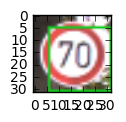

In [89]:
import random

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
coord=train['coords'][index]
drawRect(image,(coord[0],coord[1]),(np.clip(coord[2],0,31),np.clip(coord[3],0,31)))
print(get_label_from_train_data(index)+ ' | coord: '+str(coord))
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print('Training set index: '+str(y_train[index]))

# Setting ANN Parameters

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# Load Existing Model to predict

In [39]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [40]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3),name="x_placeholder")
y = tf.placeholder(tf.int32, (None),name="y_placeholder")
one_hot_y = tf.one_hot(y, 43)
rate = 0.001
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [91]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

EPOCHS = 50
BATCH_SIZE = 256

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess =tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training [Do not run next cell unless you want to train)

In [92]:


with tf.Session() as sess:
    #calc_time=time.time
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    total_time=0
    print("Training...")
    print()
    for i in range(EPOCHS):
        tx_time=time.time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        tx_time = time.time()-tx_time
        total_time+=tx_time
        print("EPOCH {}/{}\t|\tTime = {:.3f} sec".format(i+1,EPOCHS,tx_time))
        print("Validation Accuracy =\t{:.3f}%".format(validation_accuracy*100))
        print()
    if(total_time>60):
        print("Total Time =\t {:.3f} min".format(total_time/60))
    else:        
        print("Total Time =\t {:.3f} sec".format(total_time))
    saver.save(sess, './lenet_assignment_1')
    print("Model saved!")

Training...

EPOCH 1/50	|	Time = 16.354 sec
Validation Accuracy =	55.968%

EPOCH 2/50	|	Time = 16.408 sec
Validation Accuracy =	79.151%

EPOCH 3/50	|	Time = 16.257 sec
Validation Accuracy =	87.044%

EPOCH 4/50	|	Time = 16.544 sec
Validation Accuracy =	90.895%

EPOCH 5/50	|	Time = 16.265 sec
Validation Accuracy =	92.068%

EPOCH 6/50	|	Time = 16.446 sec
Validation Accuracy =	92.833%

EPOCH 7/50	|	Time = 16.302 sec
Validation Accuracy =	93.242%

EPOCH 8/50	|	Time = 16.436 sec
Validation Accuracy =	94.313%

EPOCH 9/50	|	Time = 16.164 sec
Validation Accuracy =	94.772%

EPOCH 10/50	|	Time = 16.319 sec
Validation Accuracy =	94.478%

EPOCH 11/50	|	Time = 16.276 sec
Validation Accuracy =	95.499%

EPOCH 12/50	|	Time = 16.426 sec
Validation Accuracy =	95.346%

EPOCH 13/50	|	Time = 16.344 sec
Validation Accuracy =	95.371%

EPOCH 14/50	|	Time = 16.472 sec
Validation Accuracy =	95.129%

EPOCH 15/50	|	Time = 16.385 sec
Validation Accuracy =	95.881%

EPOCH 16/50	|	Time = 16.531 sec
Validation Accuracy

Restore LeNet

In [123]:
import tensorflow as tf
saver = tf.train.Saver()
#xx = tf.placeholder(shape=[None, 32, 32, 3], dtype=tf.float32)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}%".format(test_accuracy*100))

Test Accuracy = 89.105%


**Predicting Single Image**
This is not the part of assignment but I want to predict a single image later I will use a video to predict traffic sign in the video frames but don't know why it is always wrong and new values :/

index [test label]# 8756
Name: Speed limit (50km/h)
Prediction: Speed limit (30km/h)


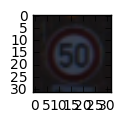

In [125]:
prediction=tf.nn.softmax(logits)
prediction_label=tf.arg_max(prediction,dimension=1)

index = random.randint(0, len(X_test))
image = X_test[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)

print('index [test label]# '+str(index))
print('Name: ' +str(get_label_from_test_data(index)))

image_4D= image.reshape(1, 32,32,3)

feed_dict = {x:image_4D}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    pred_test = sess.run(prediction_label,feed_dict)
    #folowing line get the name from csv list of labels
    print('Prediction: '+str(get_name_of_the_label(pred_test.all())))
    plt.imshow(image)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [90]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

Dataset is already organised, I just split test data into 20% validation and 80% test data then shuffle it.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [83]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

I set 20% validation data from test data. and shuffle test data.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [84]:
### Train your model here.
### Feel free to use as many code cells as needed.

I used Lenet model, 50 epoch, batch size 256, 5 layers.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Adam Optimizer (learning rate = 0.001) | batch size = 256 | 50 epochs | hyperparameters: initial layer wight Normalizd(0 mean and 0.1 sigma) | input size (?,32,32,3)

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

first I use Lenet soulution I want to train color image not grayscale but the architecture Lenet code was set for single channel so I changed 1st layer. and also the output size of labels in the very last layer.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

index [test label]# 3166
Name: Vehicles over 3.5 metric tons prohibited
Prediction: Speed limit (30km/h)


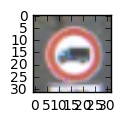

In [147]:
#prediction=tf.nn.softmax(logits)  #already assigned above
#prediction_label=tf.arg_max(prediction,dimension=1)  #already assigned above

index_test = random.randint(0, len(X_test))
image_test = X_test[index_test].squeeze()

plt.figure(figsize=(1,1))
#plt.imshow(image_test)

print('index [test label]# '+str(index_test))
print('Name: ' +str(get_label_from_test_data(index_test)))

image_4D= image_test.reshape(1, 32,32,3)

feed_dict = {x:image_4D}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    pred_test = sess.run(prediction_label,feed_dict)
    #folowing line get the name from csv list of labels
    print('Prediction: '+str(get_name_of_the_label(pred_test.all())))
    plt.imshow(image_test)

Don't know whats wrong it is not predicting atleast ~10% from the test dataset

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [86]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [149]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.